In [9]:
# Imports
import os
import shutil
import matplotlib
import pybullet_envs2

from acme.utils import loggers
from acme.tf import networks
from acme.tf import utils as tf2_utils
from acme.agents.tf.d4pg import D4PG
from acme.agents.tf.ddpg import DDPG
from acme.agents.tf.dmpo import DistributionalMPO
from acme import wrappers, specs, environment_loop

import numpy as np
import sonnet as snt
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# from google.colab import drive
from IPython.display import HTML

from pybullet_envs2.gym_locomotion_envs import HopperBulletEnv
from pybullet_envs2.gym_locomotion_envs import Walker2DBulletEnv
from pybullet_envs2.gym_locomotion_envs import HalfCheetahBulletEnv
from pybullet_envs2.gym_locomotion_envs import AntBulletEnv
from pybullet_envs2.gym_locomotion_envs import AntBulletEnv
from pybullet_envs2.gym_locomotion_envs import HumanoidFlagrunBulletEnv, HumanoidFlagrunHarderBulletEnv

# perfect our own instance of the enviroment is created
# time to manipulate the environments
print(pybullet_envs2.getList())

# @title Figure settings
import ipywidgets as widgets       # interactive display
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/content-creation/main/nma.mplstyle")

['- HumanoidDeepMimicBackflipBulletEnv-v1', '- HumanoidDeepMimicWalkBulletEnv-v1', '- CartPoleBulletEnv-v1', '- CartPoleContinuousBulletEnv-v0', '- MinitaurBulletEnv-v0', '- MinitaurBulletDuckEnv-v0', '- RacecarBulletEnv-v0', '- RacecarZedBulletEnv-v0', '- KukaBulletEnv-v0', '- KukaCamBulletEnv-v0', '- InvertedPendulumBulletEnv-v0', '- InvertedDoublePendulumBulletEnv-v0', '- InvertedPendulumSwingupBulletEnv-v0', '- ReacherBulletEnv-v0', '- PusherBulletEnv-v0', '- ThrowerBulletEnv-v0', '- Walker2DBulletEnv-v0', '- HalfCheetahBulletEnv-v0', '- AntBulletEnv-v0', '- HopperBulletEnv-v0', '- HumanoidBulletEnv-v0', '- HumanoidFlagrunBulletEnv-v0', '- HumanoidFlagrunHarderBulletEnv-v0', '- MinitaurExtendedEnv-v0', '- MinitaurReactiveEnv-v0', '- MinitaurBallGymEnv-v0', '- MinitaurTrottingEnv-v0', '- MinitaurStandGymEnv-v0', '- MinitaurAlternatingLegsEnv-v0', '- MinitaurFourLegStandEnv-v0', '- KukaDiverseObjectGrasping-v0']


In [10]:
import pybullet_data2
pybullet_data2.getDataPath()

'/home/vanillaskies/projects/nma2/robolympics-git2/pybullet_data2'

In [11]:
def save_ckpt_to_drive(agent):
  """Saves agent checkpoint directory to Google Drive.

  WARNING: Will replace the entire content of the
  drive directory `/root/drive/MyDrive/acme_ckpt`.

  Args:
    agent: core.Actor
  """
  src = agent._learner._checkpointer._checkpoint_manager.directory
  dst = '/root/drive/MyDrive/acme_ckpt'
  if os.path.exists(dst):
    shutil.rmtree(dst)
  shutil.copytree(src, dst)
  print(f'Saved {src} to {dst}')


def restore_ckpt_from_drive(agent):
  """Restores agent checkpoint directory from Google Drive.

  The name of the local checkpoint directory will be different
  than it was when the checkpoint was originally saved.
  This is because `acme` checkpoiner creates a new directory
  upon restart.

  WARNING: Will replace the entire content of the local
  checkpoint directory (if it exists already).

  Args:
    agent: core.Actor
  """
  src = '/root/drive/MyDrive/acme_ckpt'
  dst = agent._learner._checkpointer._checkpoint_manager.directory
  if os.path.exists(dst):
        shutil.rmtree(dst)
  shutil.copytree(src, dst)
  print(f'Restored {dst} from {src}')
    
def display_video(frames, framerate=30):
  """Generates video from `frames`.

  Args:
    frames (ndarray): Array of shape (n_frames, height, width, 3).
    framerate (int): Frame rate in units of Hz.

  Returns:
    Display object.
  """
  height, width, _ = frames[0].shape
  dpi = 70
  orig_backend = matplotlib.get_backend()
  matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
  fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
  matplotlib.use(orig_backend)  # Switch back to the original backend.
  ax.set_axis_off()
  ax.set_aspect('equal')
  ax.set_position([0, 0, 1, 1])
  im = ax.imshow(frames[0])
  def update(frame):
    im.set_data(frame)
    return [im]
  interval = 1000/framerate
  anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                  interval=interval, blit=True, repeat=False)
  return HTML(anim.to_html5_video())

def make_networks_d4pg(action_spec,
                       policy_layer_sizes=(256, 256, 256),
                       critic_layer_sizes=(512, 512, 256),
                       vmin=-150.,
                       vmax=150.,
                       num_atoms=51,
                      ):
  """Networks for D4PG agent."""
  action_size = np.prod(action_spec.shape, dtype=int)

  policy_network = snt.Sequential([
      tf2_utils.batch_concat,
      networks.LayerNormMLP(layer_sizes=policy_layer_sizes + (action_size,)),
      networks.TanhToSpec(spec=action_spec)
      ])
  critic_network = snt.Sequential([
      networks.CriticMultiplexer(
          action_network=networks.ClipToSpec(action_spec),
          critic_network=networks.LayerNormMLP(
              layer_sizes=critic_layer_sizes,
              activate_final=True),
      ),
      networks.DiscreteValuedHead(vmin=vmin,
                                  vmax=vmax,
                                  num_atoms=num_atoms)
      ])

  return policy_network, critic_network


def make_networks_ddpg(action_spec,
                       policy_layer_sizes=(256, 256, 256),
                       critic_layer_sizes=(512, 512, 256),
                      ):
  """Networks for DDPG agent."""
  action_size = np.prod(action_spec.shape, dtype=int)

  policy_network = snt.Sequential([
      tf2_utils.batch_concat,
      networks.LayerNormMLP(layer_sizes=policy_layer_sizes + (action_size,)),
      networks.TanhToSpec(spec=action_spec)
      ])
  critic_network = networks.CriticMultiplexer(
          action_network=networks.ClipToSpec(action_spec),
          critic_network=networks.LayerNormMLP(
              layer_sizes=critic_layer_sizes + (1,),
              activate_final=False),
              )

  return policy_network, critic_network


def make_networks_dmpo(action_spec,
                       policy_layer_sizes=(256, 256, 256),
                       critic_layer_sizes=(512, 512, 256),
                       vmin=-150.,
                       vmax=150.,
                       num_atoms=51,
                      ):
  """Networks for DMPO agent."""
  action_size = np.prod(action_spec.shape, dtype=int)

  policy_network = snt.Sequential([
      tf2_utils.batch_concat,
      networks.LayerNormMLP(layer_sizes=policy_layer_sizes,
                            activate_final=True),
      networks.MultivariateNormalDiagHead(
          action_size,
          min_scale=1e-6,
          tanh_mean=False,
          init_scale=0.7,
          fixed_scale=False,
          use_tfd_independent=True)
  ])

  # The multiplexer concatenates the (maybe transformed) observations/actions.
  critic_network = networks.CriticMultiplexer(
      action_network=networks.ClipToSpec(action_spec),
      critic_network=networks.LayerNormMLP(layer_sizes=critic_layer_sizes,
                                           activate_final=True),
                                           )
  critic_network = snt.Sequential([
                                   critic_network,
                                   networks.DiscreteValuedHead(vmin=vmin,
                                                               vmax=vmax,
                                                               num_atoms=num_atoms)
                                   ])

  return policy_network, critic_network


checkpoints_stadium = np.array([[36.90058899,  -3.27299237],
       [ 29.98545074, -15.73727989],
       [ 25.98292923,  19.71592522],
       [ 36.00297928,   7.93183422],
       [-36.00297928,  -6.91670513],
       [-28.69959831,  17.92435074],
       [-34.2795639 ,  11.62551594],
       [ 37.12164688,   2.41725087],
       [-32.95801163, -12.49569416],
       [-36.90058899,   4.28812122],
       [ 35.49053192,  -7.93686962],
       [ 26.26033592, -18.4656353 ],
       [-17.51765633,  22.4084053 ],
       [ 33.36088181, -11.92537308],
       [-23.28717995,  20.93785286],
       [-37.12164688,  -1.40212178],
       [ 24.69773293, -19.26901054],
       [ 30.10389709,  16.65581703],
       [-28.98753738, -16.69599724],
       [ 32.958004  ,  13.51084328],
       [-24.59379959, -19.27071381],
       [ 18.29857635,  22.3815155 ],
       [ 17.46794701, -21.23395348],
       [-20.45232391, -20.74229622],
       [-17.62427711, -21.17273331],
       [ 23.09788132, -19.88587952],
       [-16.22319412, -21.3013134 ],
       [-26.827631  , -21.17273331]])


class HumanoidInitialize(HumanoidFlagrunBulletEnv):
  def __init__(self, render=False, episode_steps=1000):
    """Modifies `__init__` in `HopperBulletEnv` parent class."""
    self.episode_steps = episode_steps
    # self.start_pos_x, self.start_pos_y, self.start_pos_z = 0, 0, 0
    # self.body_xyz = [28, -20, 5]
    self.walk_target_x = checkpoints_stadium[0, 0]
    self.walk_target_y = checkpoints_stadium[0, 1]
    # self.basePosition = [28, -20, 5]
    super().__init__(render=render)

  def reset(self):
    """Modifies `reset` in `WalkerBaseBulletEnv` base class."""
    self.step_counter = 0
    return super().reset()

  def _isDone(self):
    """Modifies `_isDone` in `WalkerBaseBulletEnv` base class."""
    return (self.step_counter == self.episode_steps
            or super()._isDone())

  def step(self, a):
    """Fully overrides `step` in `WalkerBaseBulletEnv` base class."""

    self.step_counter += 1

    # if multiplayer, action first applied to all robots,
    # then global step() called, then _step() for all robots
    # with the same actions
    if not self.scene.multiplayer:
      self.robot.apply_action(a)
      self.scene.global_step()

    state = self.robot.calc_state()  # also calculates self.joints_at_limit

    # state[0] is body height above ground, body_rpy[1] is pitch
    self._alive = float(self.robot.alive_bonus(state[0] + self.robot.initial_z,
                                               self.robot.body_rpy[1]))
    done = self._isDone()
    if not np.isfinite(state).all():
      print("~INF~", state)
      done = True

    potential_old = self.potential
    self.potential = self.robot.calc_potential()
    progress = float(self.potential - potential_old)

    feet_collision_cost = 0.0
    for i, f in enumerate(self.robot.feet):
      contact_ids = set((x[2], x[4]) for x in f.contact_list())
      if (self.ground_ids & contact_ids):
        self.robot.feet_contact[i] = 1.0
      else:
        self.robot.feet_contact[i] = 0.0

    # let's assume we have DC motor with controller, and reverse current braking
    electricity_cost = self.electricity_cost * float(
        np.abs(a * self.robot.joint_speeds).mean())
    electricity_cost += self.stall_torque_cost * float(np.square(a).mean())

    joints_at_limit_cost = float(self.joints_at_limit_cost * self.robot.joints_at_limit)

    self.rewards = [
                    self._alive, progress, electricity_cost,
                    joints_at_limit_cost, feet_collision_cost
                    ]
    self.HUD(state, a, done)
    self.reward += sum(self.rewards)

    return state, sum(self.rewards), bool(done), {}


env = HumanoidInitialize()
env = wrappers.GymWrapper(env)
env = wrappers.SinglePrecisionWrapper(env)
action_spec = env.action_spec()  # Specifies action shape and dimensions.
env_spec = specs.make_environment_spec(env)
print(env.robot.walk_target_x, env.robot.walk_target_y)

1000.0 0


/home/vanillaskies/anaconda3/envs/mne/lib/python3.9/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


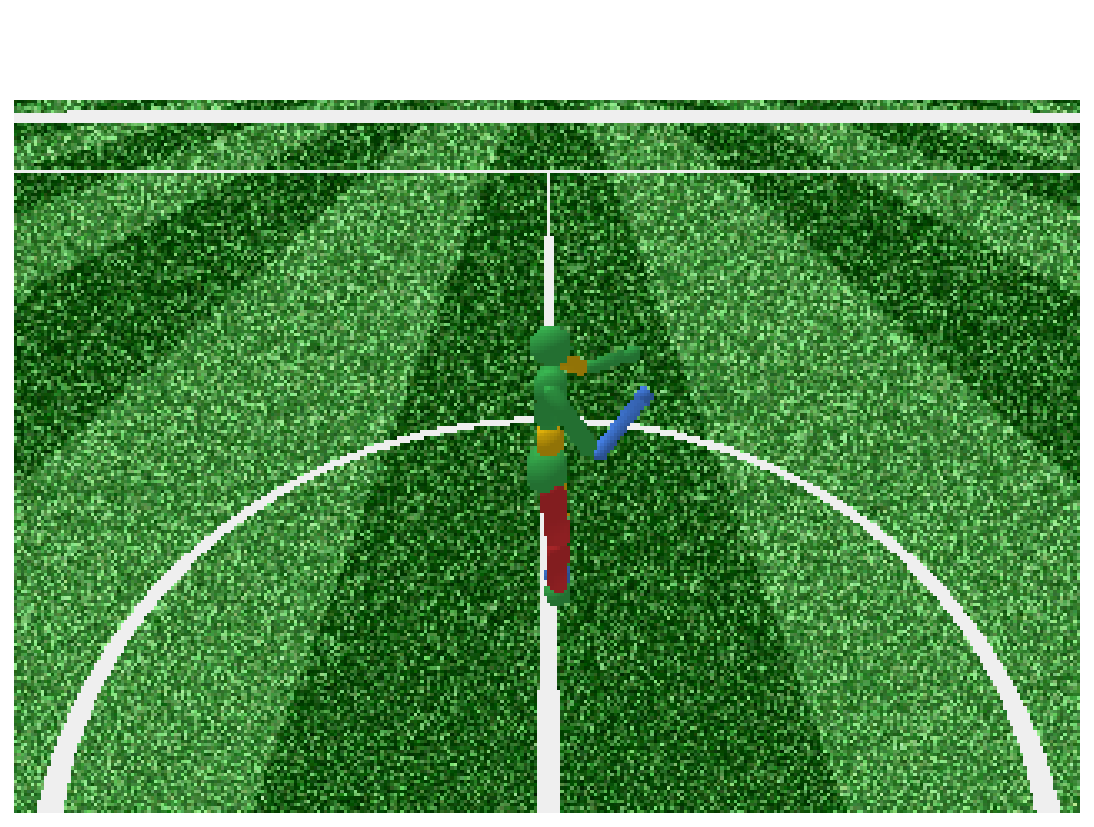

In [12]:
_ = env.reset()

frame = env.environment.render(mode='rgb_array')
plt.imshow(frame)
plt.axis('off')
plt.show()

In [ ]:
n_steps = 200

frames = []
timestep = env.reset()
for _ in range(n_steps):
  # Random control of actuators.
  action = np.random.uniform(15,
                             15,
                             size=15)
  timestep = env.step(action)
  frames.append(env.environment.render(mode='rgb_array'))

display_video(frames, framerate=20)

In [ ]:
# check gravity

print(len(action_spec.minimum))

In [ ]:
print('Actions:\n', env_spec.actions)
print('Observations:\n', env_spec.observations)
print('Rewards:\n', env_spec.rewards)

In [ ]:
for body_part in env.robot.parts.keys():
  print(f"{body_part:10} {env.robot.parts[body_part].pose().xyz()}")

In [ ]:
env.robot_body.speed()

In [ ]:
learner_log_every = 60.  # Learner logging frequency, seconds.
loop_log_every = 60.  # Environment loop logging frequency, seconds.
checkpoint = True  # Checkpoint saved every 10 minutes.

learner_logger = loggers.TerminalLogger(label='Learner',
                                        time_delta=learner_log_every,
                                        print_fn=print)
loop_logger = loggers.TerminalLogger(label='Environment Loop',
                                     time_delta=loop_log_every,
                                     print_fn=print)

# Note: optimizers can be passed only to the D4PG and DMPO agents.
# The optimizer for DDPG is hard-coded in the agent class.
policy_optimizer = snt.optimizers.Adam(1e-4)
critic_optimizer = snt.optimizers.Adam(1e-4)

In [ ]:
# Create networks.
policy_network, critic_network = make_networks_d4pg(action_spec)

# Create agent.
agent = D4PG(environment_spec=env_spec,
             policy_network=policy_network,
             critic_network=critic_network,
             observation_network=tf2_utils.batch_concat, # Identity Op.
             policy_optimizer=policy_optimizer,
             critic_optimizer=critic_optimizer,
             logger=learner_logger,
             checkpoint=checkpoint)

In [ ]:
num_steps = 100# 100_000  # Number of environment loop steps. Adjust as needed!

loop = environment_loop.EnvironmentLoop(env, agent, logger=loop_logger)

# Start training!
loop.run(num_episodes=None,
         num_steps=num_steps)

In [ ]:
env_step = 0
for episode in reward:
  plt.plot(np.arange(env_step, env_step+len(episode)), episode)
  env_step += len(episode)
plt.xlabel('Timestep', fontsize=14)
plt.ylabel('Reward', fontsize=14)
plt.grid()
plt.show()

In [ ]:
for i, episode in enumerate(reward):
  print(f"Total reward in episode {i}: {sum(episode):.2f}")

In [ ]:
# Run the environment with the learned policy and display video.
n_steps = 500

frames = []  # Frames for video.
reward = [[]]  # Reward at every timestep.
timestep = env.reset()
for _ in range(n_steps):
  frames.append(env.environment.render(mode='rgb_array').copy())
  action = agent.select_action(timestep.observation)
  timestep = env.step(action)

  # `timestep.reward` is None when episode terminates.
  if timestep.reward:
    # Old episode continues.
    reward[-1].append(timestep.reward.item())
  else:
    # New episode begins.
    reward.append([])

display_video(frames)